In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from display_lib import html_table, violinplot, errorbar, ranks, rank_colors
from statsmodels.api import OLS, add_constant
import pickle

In [2]:
data = pd.read_pickle('summaries\\data_frame')

In [4]:
def show_regressions(x):
  # initialize the figure
  gs = plt.GridSpec(19, 2)
  plt.figure(figsize=(15, 75))

  models = {}

  data_ = data.drop(['title', 'duration', 'shots', 'goals', 'saves', 'score'], axis=1)
  for i, (metric, df) in enumerate(data_.iteritems()):
    # separate metrics into distributions by rank
    _, series = zip(*df.groupby('rank'))

    # create error bar plots by rank
    plt.subplot(gs[i, 0])
    errorbar(series)
    plt.title('Mean and Stdev by Rank')
    plt.ylabel(metric)

    # create a linear regression model for the metric
    model = OLS(df, x)
    res = model.fit()
    models[metric] = res

    # calculate the residuals from the linear model
    df_res = df.subtract((x * res.params.array).sum(axis=1))
    # separate into distributions by rank
    _, series = zip(*df_res.groupby('rank'))

    # create a violin and error bar plots for residuals
    plt.subplot(gs[i, 1])
    errorbar(series)
    violinplot(series)
    plt.title('Regression Residuals by Rank')

  # show the figure
  plt.tight_layout()
  plt.show()

  return models

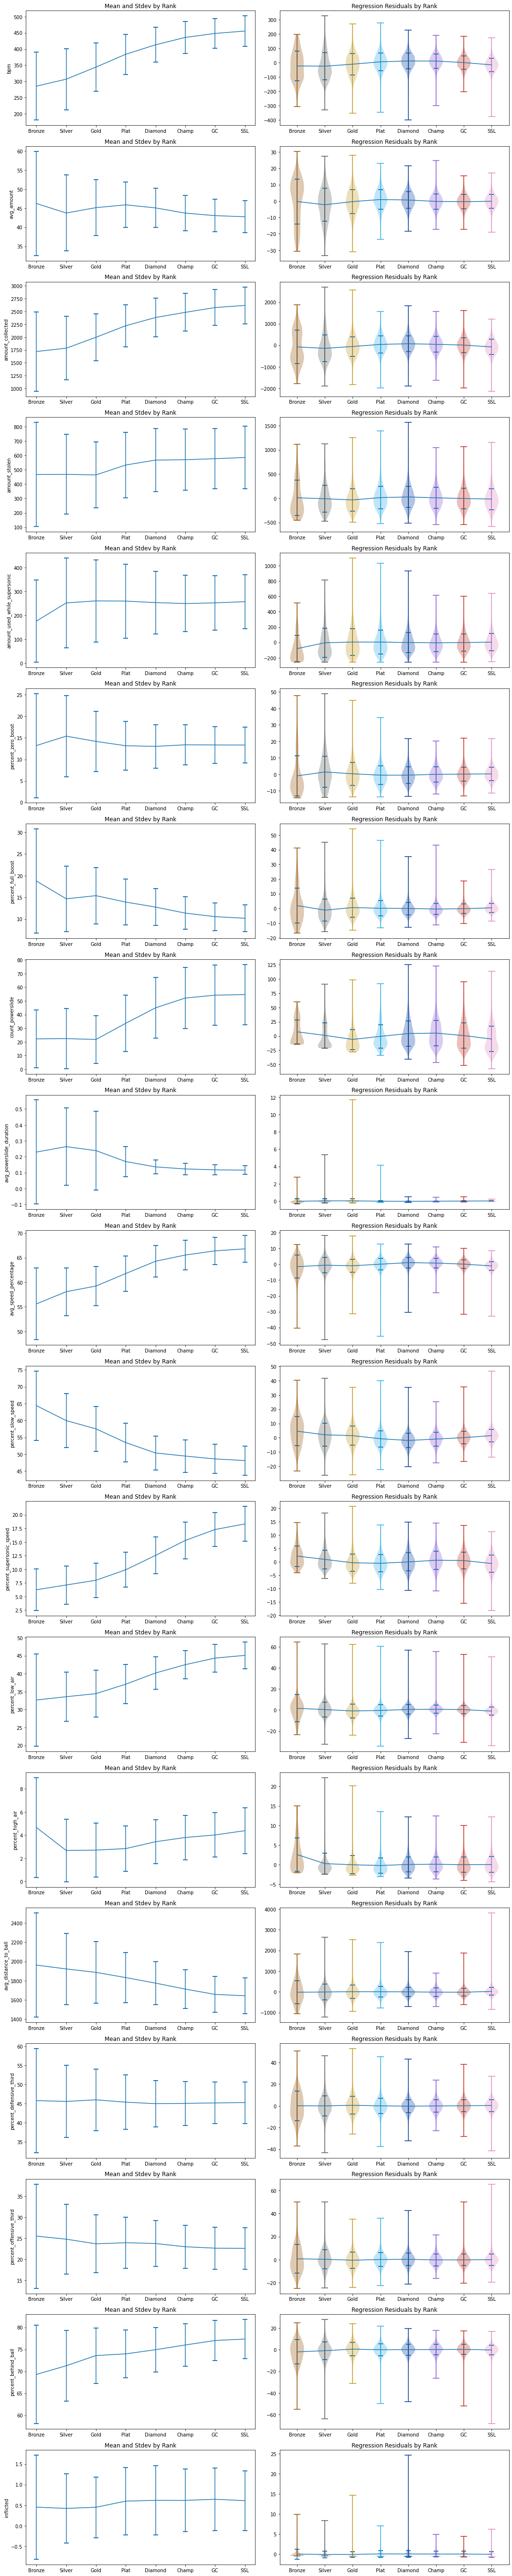

In [5]:
# create x values for regression
r = data.index.get_level_values('rank')
r = r.map(dict((r, i) for i, r in enumerate(ranks)))
x = add_constant(r)

models = show_regressions(x)

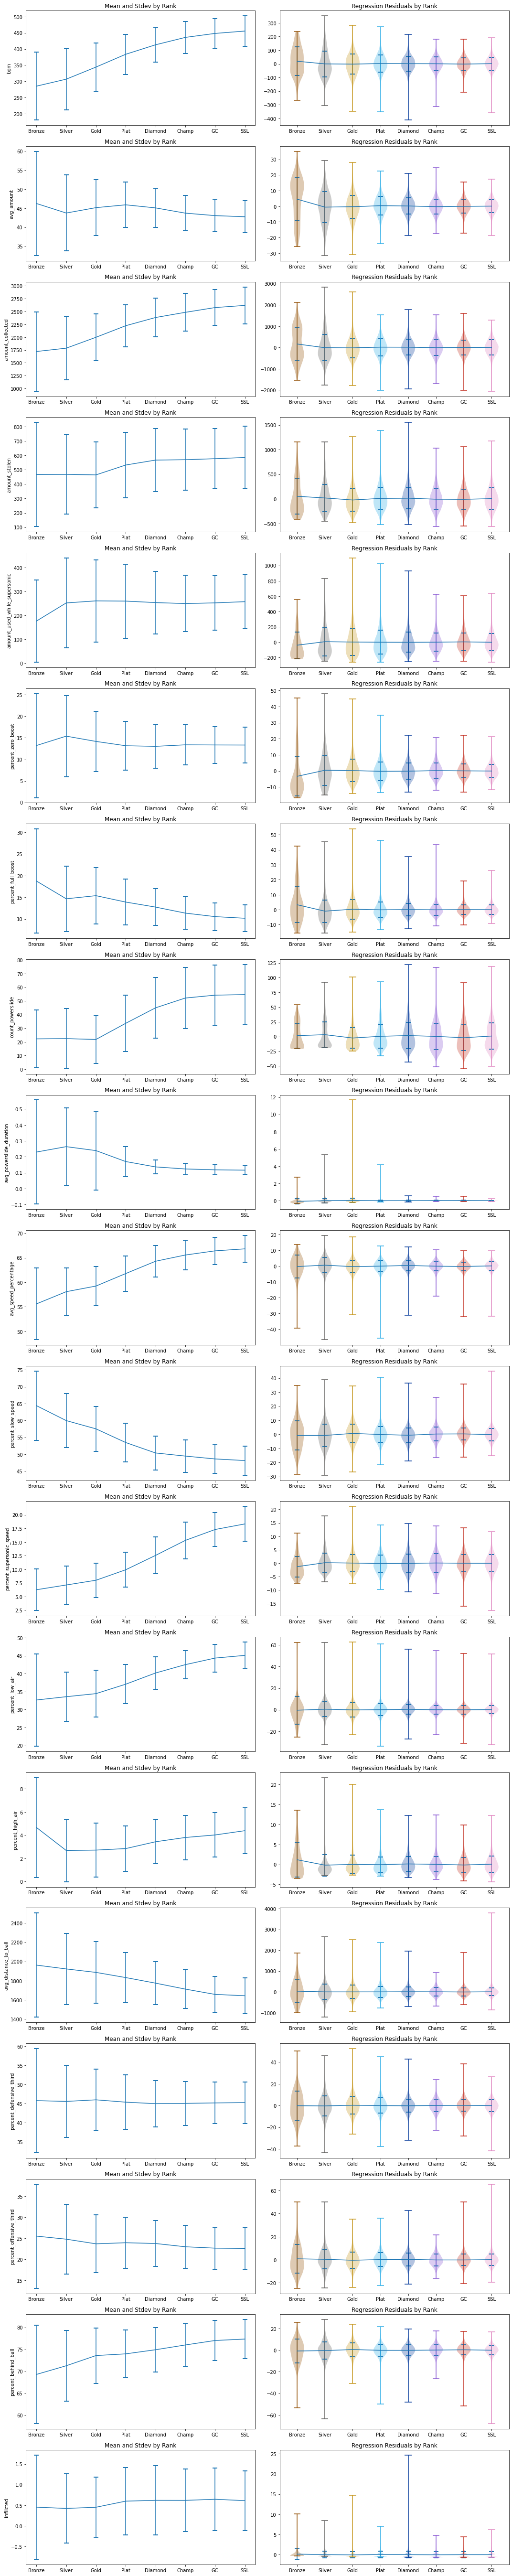

In [6]:
# create higher-dimensional x values for regression
x = np.array([(r - 3.5)**i for i in range(4)]).T

cube_models = show_regressions(x)

In [7]:
for metric in [
  'avg_amount', 'amount_stolen', 'amount_used_while_supersonic', 'percent_zero_boost',
  'percent_full_boost', 'count_powerslide', 'percent_high_air'
]:
  cube_models.pop(metric)

In [10]:
# calculate goal differences for each game
diff = data.drop(['title', 'duration'], axis=1).diff()[1::2]

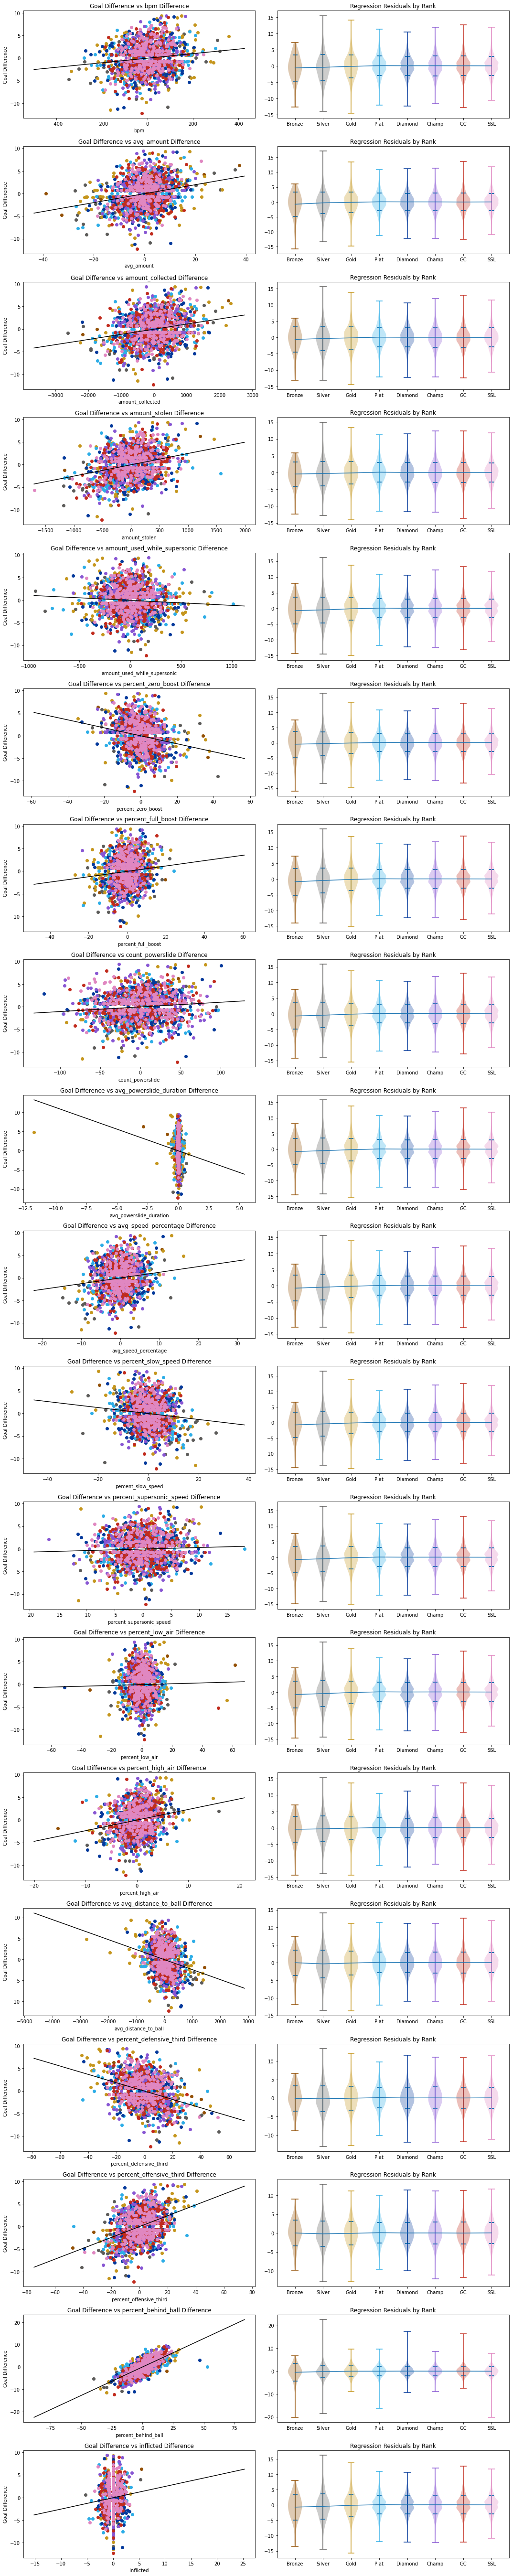

In [12]:
# initialize the figure
gs = plt.GridSpec(19, 2)
plt.figure(figsize=(15, 75))

diff_models = {}
y = diff['goals']
_, ygb = zip(*y.groupby('rank'))

diff_ = diff.drop(['shots', 'goals', 'saves', 'score'], axis=1)
for i, (metric, df) in enumerate(diff_.iteritems()):
  # separate metrics into distributions by rank
  _, series = zip(*df.groupby('rank'))

  # create a regression model for all ranks
  x = add_constant(df)
  model = OLS(y, x)
  res = model.fit()
  diff_models[metric] = res

  # create a scatterplot of goal difference vs metric
  plt.subplot(gs[i, 0])
  for xs, ys, cs in zip(series, ygb, rank_colors):
    # only plot 1 in 10 points since there are so many
    plt.scatter(xs[::10], ys[::10], c=[cs])
  plt.title(f'Goal Difference vs {metric} Difference')
  plt.xlabel(metric)
  plt.ylabel('Goal Difference')

  # plot the regression line over the scatterplot
  xf = np.linspace(df.min(), df.max(), 2)
  yf = (add_constant(xf) * res.params.array).sum(axis=1)
  plt.plot(xf, yf, color='black')

  # calculate regression residuals by rank
  df_res = y.subtract((x * res.params.array).sum(axis=1))
  _, series = zip(*df_res.groupby('rank'))

  # create a violin and error bar plots for residuals
  plt.subplot(gs[i, 1])
  errorbar(series)
  violinplot(series)
  plt.title('Regression Residuals by Rank')

# show the figure
plt.tight_layout()
plt.show()

In [10]:
for metric in [
  'amount_stolen', 'percent_zero_boost', 'percent_full_boost',
  'percent_defensive_third', 'percent_offensive_third'
]:
  diff_models.pop(metric)

In [11]:
with open('summaries\\models', 'wb') as f:
  pickle.dump((cube_models, diff_models), f)